### Bibliotheken

In [1]:
import os
import sys
ImportWarning 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import shap

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy.stats.mstats import winsorize
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from catboost import CatBoostClassifier
from sklearn import tree
from pycaret.classification import *

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


### Datengrundlage

In [ ]:
# Aktueller Pfad:
print ("Ihr Pfad:", os.getcwd())

# Prüfung, ob die Datei vorhanden ist:
if not os.path.isfile("apple_quality.csv"):
    print("apple_quality.csv nicht gefunden. Vielen Dank, Sie es in den aktuellen Pfad speichern:", os.getcwd())
else:    
    print("apple_quality.csv gefunden.")

In [3]:
# CSV und Pandas-Dataframe
df = pd.read_csv('apple_quality.csv')
df.head()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
0,0.0,-3.970049,-2.512336,5.346330,-1.012009,1.844900,0.329840,-0.491590483,good
1,1.0,-1.195217,-2.839257,3.664059,1.588232,0.853286,0.867530,-0.722809367,good
2,2.0,-0.292024,-1.351282,-1.738429,-0.342616,2.838636,-0.038033,2.621636473,bad
3,3.0,-0.657196,-2.271627,1.324874,-0.097875,3.637970,-3.413761,0.790723217,good
4,4.0,1.364217,-1.296612,-0.384658,-0.553006,3.030874,-1.303849,0.501984036,good


### Datengrundlage

In [4]:
# Anzahl der Zeilen und Spalten
df.shape

(4001, 9)

In [5]:
# Datentypen
df.dtypes

A_id           float64
Size           float64
Weight         float64
Sweetness      float64
Crunchiness    float64
Juiciness      float64
Ripeness       float64
Acidity         object
Quality         object
dtype: object

### Datenquantiät und -qualität

In [6]:
# Einträge ohne A_id
df[df.A_id.isnull()]

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality
4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Created_by_Nidula_Elgiriyewithana,NaN


In [7]:
# Entfernen der Zeile ohne A_id
df = df.dropna(subset=['A_id'])
print("Anzahl der Zeilen ohne A_id:", df[df.A_id.isnull()].shape[0])

# Kontrolle
df[df.A_id.isnull()]

Anzahl der Zeilen ohne A_id: 0


,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality


In [8]:
# Umwandlung der Acidity float64
df['Acidity'] = df['Acidity'].astype('float64')
df.dtypes

A_id           float64
Size           float64
Weight         float64
Sweetness      float64
Crunchiness    float64
Juiciness      float64
Ripeness       float64
Acidity        float64
Quality         object
dtype: object

In [9]:
df.describe()

,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,1999.500000,-0.503015,-0.989547,-0.470479,0.985478,0.512118,0.498277,0.076877
std,1154.844867,1.928059,1.602507,1.943441,1.402757,1.930286,1.874427,2.110270
min,0.000000,-7.151703,-7.149848,-6.894485,-6.055058,-5.961897,-5.864599,-7.010538
25%,999.750000,-1.816765,-2.011770,-1.738425,0.062764,-0.801286,-0.771677,-1.377424
50%,1999.500000,-0.513703,-0.984736,-0.504758,0.998249,0.534219,0.503445,0.022609
75%,2999.250000,0.805526,0.030976,0.801922,1.894234,1.835976,1.766212,1.510493
max,3999.000000,6.406367,5.790714,6.374916,7.619852,7.364403,7.237837,7.404736


In [10]:
# Prüfung auf Duplikate: falls ja, löschen
df.duplicated()
df.duplicated().sum()
print("Anzahl der Duplikate:", df.duplicated().sum())

# Löschen der Duplikate
df = df.drop_duplicates()
df.duplicated().sum()
print("Anzahl der gelöschten Duplikate:", df.duplicated().sum())

# Kontrolle
df[df.duplicated()]

Anzahl der Duplikate: 0
Anzahl der gelöschten Duplikate: 0


,A_id,Size,Weight,Sweetness,Crunchiness,Juiciness,Ripeness,Acidity,Quality


In [11]:
# Prüfung auf leere Werte
df.isnull()

# Anzahl der leeren Werte
df.isnull().sum()

A_id           0
Size           0
Weight         0
Sweetness      0
Crunchiness    0
Juiciness      0
Ripeness       0
Acidity        0
Quality        0
dtype: int64

In [12]:
#  Wertvarianten der Spalte Quality
df.Quality.unique()

array(['good', 'bad'], dtype=object)

### Datenanalyse

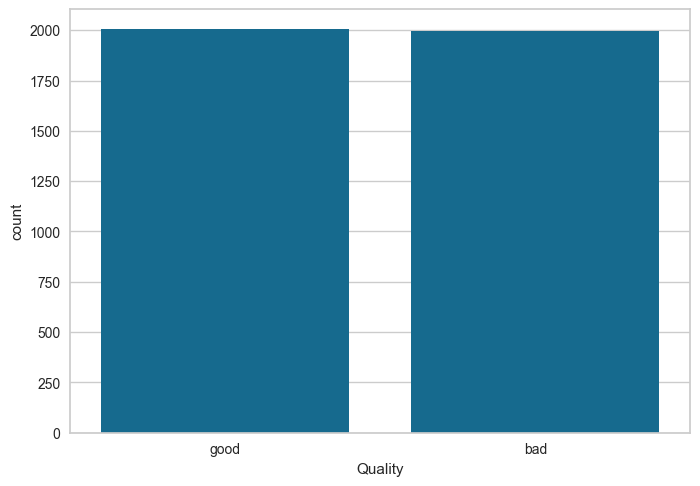

Anzahl der bad: 1996
Anzahl der good: 2004


In [13]:
# Balkendiagramm der Spalte Quality
sns.countplot(x='Quality', data=df)
plt.show()

print("Anzahl der bad:", df[df.Quality == 'bad'].shape[0])
print("Anzahl der good:", df[df.Quality == 'good'].shape[0])

In [14]:
# ersetzen der Werte in der Spalte Quality durch numerische Werte
df['Quality'] = df['Quality'].replace('good', 1)
df['Quality'] = df['Quality'].replace('bad', 0)

# Kontrolle
df.Quality.unique()

array([1, 0], dtype=int64)

### KDE-Plots für jede Kategorie

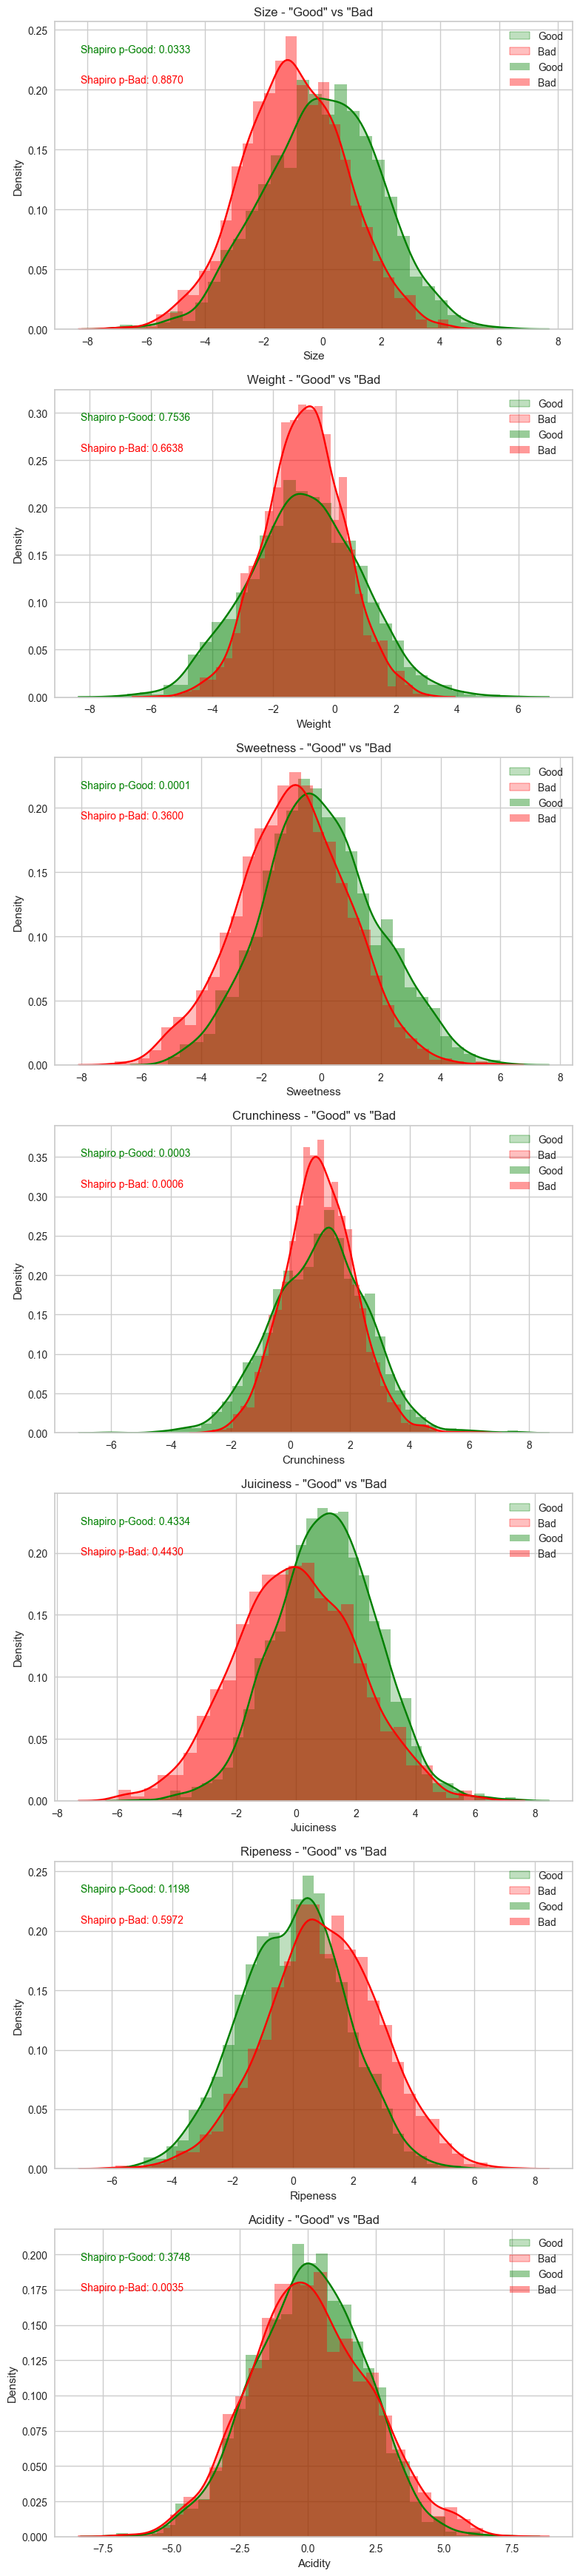

In [15]:
# Kategorien
categories = df.columns[1:8]  # ohne A_id

# Festlegen der Grösse für jeden Plot
fig, axes = plt.subplots(nrows=len(categories), figsize=(8, 5 * len(categories)))

# Schleife durch jede Kategorie
for i, category in enumerate(categories):
    # Aufteilen der Daten nach "Good" und "Bad"
    good_data = df[df['Quality'] == 1][category]
    bad_data = df[df['Quality'] == 0][category]

    # KDE
    sns.kdeplot(good_data, label='Good', fill=True, color='green', ax=axes[i])
    sns.kdeplot(bad_data, label='Bad', fill=True, color='red', ax=axes[i])

    # Histogramm
    sns.distplot(good_data, label='Good', color='green', ax=axes[i])
    sns.distplot(bad_data, label='Bad', color='red', ax=axes[i])

    # Shapiro-Wilk-Test
    shapiro_good = stats.shapiro(good_data)
    shapiro_bad = stats.shapiro(bad_data)

    # Ausgabe des p-Werts
    axes[i].text(0.05, 0.9, f"Shapiro p-Good: {shapiro_good.pvalue:.4f}", transform=axes[i].transAxes, fontsize=10, color='green')
    axes[i].text(0.05, 0.8, f"Shapiro p-Bad: {shapiro_bad.pvalue:.4f}", transform=axes[i].transAxes, fontsize=10, color='red')

    # Einstellungen für den Plot
    axes[i].set_title(f'{category} - "Good" vs "Bad')
    axes[i].legend()

# Anpassen der Layouts
plt.tight_layout()
plt.show()


## Quantile-Quantile Plots

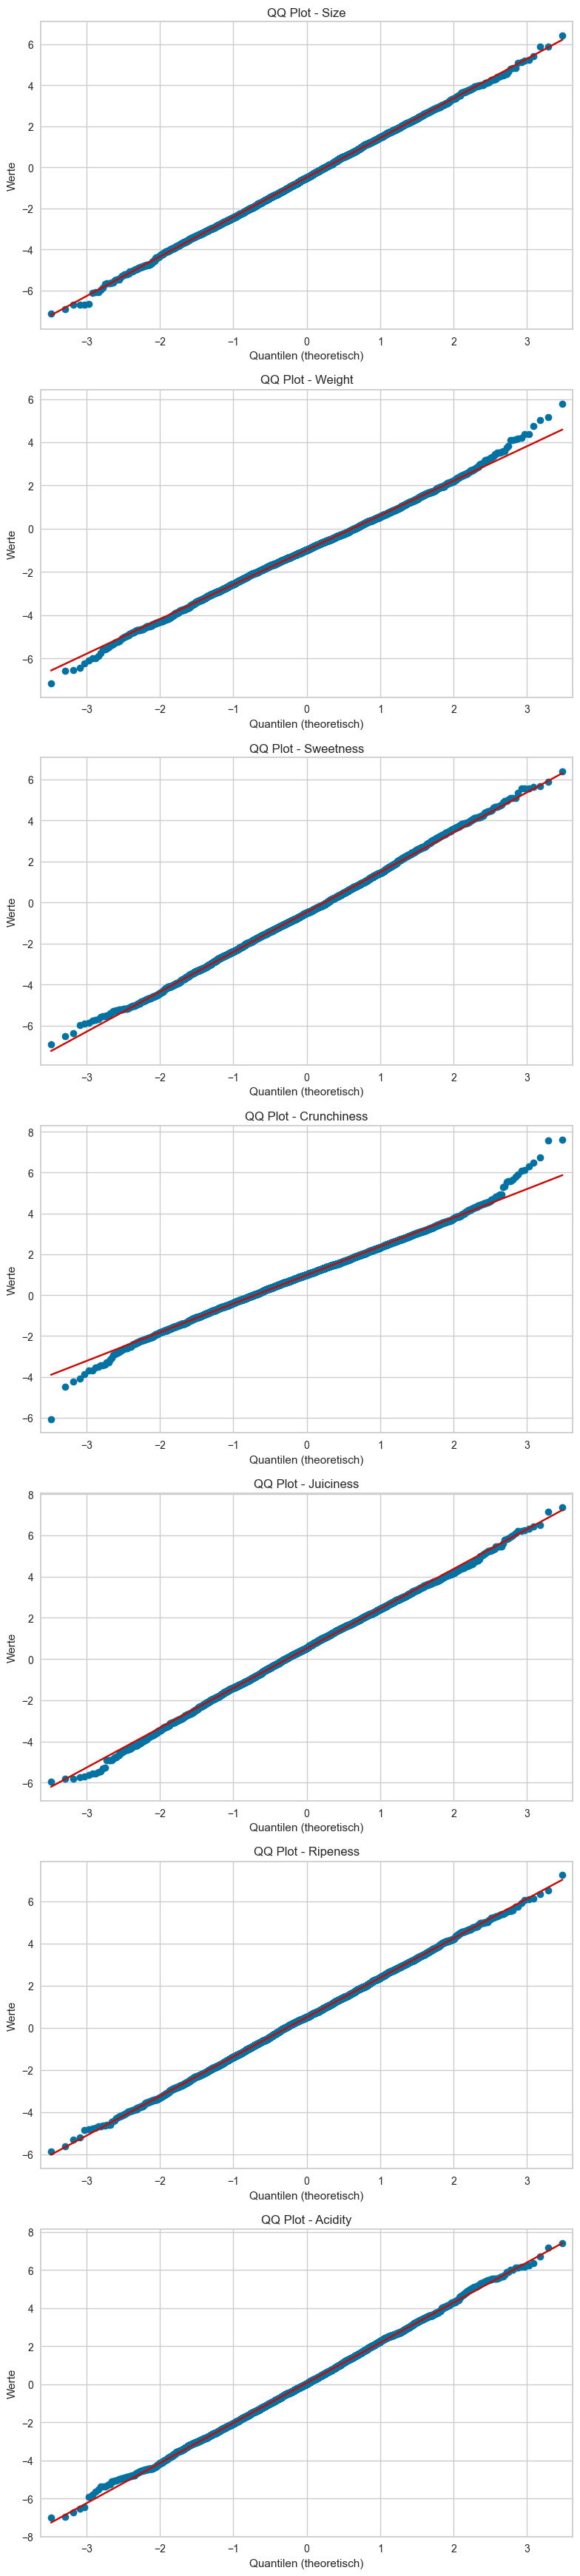

In [16]:
# Kategorien
categories = df.columns[1:8]

# Plotten der Quantile
fig, axes = plt.subplots(nrows=len(categories), figsize=(8, 5 * len(categories)))

for i, category in enumerate(categories):
    # QQ-Plot für die aktuelle Kategorie
    sm.qqplot(df[category], line='s', ax=axes[i])
    axes[i].set_title(f'QQ Plot - {category}')
    axes[i].set_xlabel(f'Quantilen (theoretisch)')
    axes[i].set_ylabel(f'Werte')

plt.tight_layout()
plt.show()

### Ausreisser

In [17]:
df_outliers = pd.DataFrame(columns=['Category', 'Outliers'])

for i, category in enumerate(categories):
    # Quantile
    q25, q75 = np.percentile(df[category], 25), np.percentile(df[category], 75)
    iqr = q75 - q25

    # Ausreisser
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off

    # Anzahl der Ausreisser
    outliers = [x for x in df[category] if x < lower or x > upper]
    df_outliers.loc[i] = [category, len(outliers)]
print("Anzahl der Ausreisser für die Kategorie Acidity:", df_outliers[df_outliers.Category == 'Acidity'].Outliers.values[0])
print("Anzahl der Ausreisser für die Kategorie Weight:", df_outliers[df_outliers.Category == 'Weight'].Outliers.values[0])
print("Anzahl der Ausreisser für die Kategorie Size:", df_outliers[df_outliers.Category == 'Size'].Outliers.values[0])
print("Anzahl der Ausreisser für die Kategorie Sweetness:", df_outliers[df_outliers.Category == 'Sweetness'].Outliers.values[0])
print("Anzahl der Ausreisser für die Kategorie Ripeness:", df_outliers[df_outliers.Category == 'Ripeness'].Outliers.values[0])
print("Anzahl der Ausreisser für die Kategorie Juiciness:", df_outliers[df_outliers.Category == 'Juiciness'].Outliers.values[0])

Anzahl der Ausreisser für die Kategorie Acidity: 20
Anzahl der Ausreisser für die Kategorie Weight: 54
Anzahl der Ausreisser für die Kategorie Size: 22
Anzahl der Ausreisser für die Kategorie Sweetness: 32
Anzahl der Ausreisser für die Kategorie Ripeness: 24
Anzahl der Ausreisser für die Kategorie Juiciness: 32


### Korrelationsmatrix

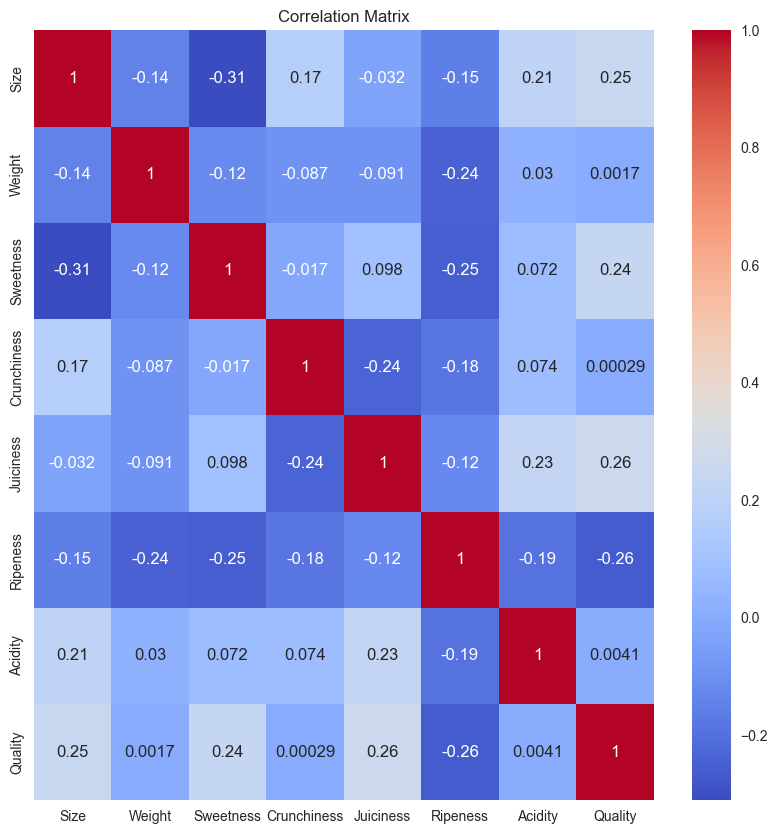

In [18]:
corr = df.drop('A_id', axis=1).corr(method='spearman') 
plt.figure(figsize=(10, 10))
plt.title('Correlation Matrix')
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [19]:
# Kopie des DataFrames
df_robust = df.copy()

# Quantitative Features
quantitative_features_Modell_01 = ['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Ripeness', 'Acidity']

# Transfomations-Pipeline
preprocessor_01 = ColumnTransformer(
    transformers=[
        ('robust_scaler', RobustScaler(), quantitative_features_Modell_01)
    ])

# Anwenden der Transformationen auf df_robust
X_01 = df_robust.drop(['A_id', 'Quality'], axis=1)
X_transformed_01 = preprocessor_01.fit_transform(X_01)

# neues DataFrame
X_transformed_df_01 = pd.DataFrame(X_transformed_01, columns=X_01.columns)

# Qualität hinzufügen
X_transformed_df_01['Quality'] = df_robust['Quality']
print(X_transformed_df_01.head())

       Size    Weight  Sweetness  Crunchiness  Juiciness  Ripeness   Acidity  \
0 -1.318063 -0.747817   2.303263    -1.097620   0.496986 -0.068405 -0.178052   
1 -0.259893 -0.907856   1.641042     0.322136   0.120984  0.143460 -0.258116   
2  0.084536 -0.179438  -0.485631    -0.732125   0.873791 -0.213358  0.899966   
3 -0.054721 -0.629980   0.720229    -0.598494   1.176884 -1.543490  0.265975   
4  0.716137 -0.152675   0.047277    -0.847000   0.946685 -0.712125  0.165993   

   Quality  
0        1  
1        1  
2        0  
3        1  
4        1  


In [20]:
from sklearn.metrics import log_loss
# Aufteilen der Daten in Trainings- und Testsets
X_train, X_test, y_train, y_test = train_test_split(X_transformed_df_01.drop('Quality', axis=1), df['Quality'], test_size=0.2, random_state=42)

# Logistische Regression
logreg_model_01 = LogisticRegression(random_state=42)
start_time = time.time()
logreg_model_01.fit(X_train, y_train)
end_time = time.time()
logreg_runtime = end_time - start_time
logreg_model_logloss = log_loss(y_test, logreg_model_01.predict_proba(X_test))

logreg_pred_01 = logreg_model_01.predict(X_test)

# Random Forest
rf_model_01 = RandomForestClassifier(random_state=42)
start_time = time.time()
rf_model_01.fit(X_train, y_train)
end_time = time.time()
rf_runtime = end_time - start_time
rf_model_logloss = log_loss(y_test, rf_model_01.predict_proba(X_test))

rf_pred_01 = rf_model_01.predict(X_test)


# Modellperformance
print("Logistische Regression:")
print(classification_report(y_test, logreg_pred_01))
print("Genauigkeit (Accuracy):", accuracy_score(y_test, logreg_pred_01))
print("Laufzeit:", logreg_runtime)
print("Logloss:", logreg_model_logloss)

print("\nRandom Forest:")
print(classification_report(y_test, rf_pred_01))
print("Genauigkeit (Accuracy):", accuracy_score(y_test, rf_pred_01))
print("Laufzeit:", rf_runtime)
print("Logloss:", rf_model_logloss)

Logistische Regression:
              precision    recall  f1-score   support

           0       0.75      0.76      0.75       401
           1       0.75      0.75      0.75       399

    accuracy                           0.75       800
   macro avg       0.75      0.75      0.75       800
weighted avg       0.75      0.75      0.75       800

Genauigkeit (Accuracy): 0.75375
Laufzeit: 0.0342555046081543
Logloss: 0.5193512062705288

Random Forest:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90       401
           1       0.89      0.90      0.90       399

    accuracy                           0.90       800
   macro avg       0.90      0.90      0.90       800
weighted avg       0.90      0.90      0.90       800

Genauigkeit (Accuracy): 0.89625
Laufzeit: 1.5763251781463623
Logloss: 0.2986835936647797


In [21]:
# Kopie des DataFrames
df_minmax = df.copy()

# Quantitative Features
quantitative_features_Modell_01B = ['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Ripeness', 'Acidity']

# Transfomations-Pipeline
preprocessor_01B = ColumnTransformer(
    transformers=[
        ('MinMaxScaler', MinMaxScaler(), quantitative_features_Modell_01B)
    ])

# Anwenden der Transformationen auf df_robust
X_01B = df_minmax.drop(['A_id', 'Quality'], axis=1)
X_transformed_01B = preprocessor_01B.fit_transform(X_01B)

# neues DataFrame
X_transformed_df_01B = pd.DataFrame(X_transformed_01B, columns=X_01B.columns)

# Qualität hinzufügen
X_transformed_df_01B['Quality'] = df_minmax['Quality']
print(X_transformed_df_01B.head())

       Size    Weight  Sweetness  Crunchiness  Juiciness  Ripeness   Acidity  \
0  0.234669  0.358370   0.922484     0.368781   0.585819  0.472770  0.452225   
1  0.439331  0.333107   0.795706     0.558928   0.511408  0.513807  0.436185   
2  0.505948  0.448092   0.388567     0.417732   0.660388  0.444693  0.668192   
3  0.479014  0.376971   0.619422     0.435629   0.720370  0.187052  0.541180   
4  0.628107  0.452317   0.490589     0.402347   0.674814  0.348084  0.521150   

   Quality  
0        1  
1        1  
2        0  
3        1  
4        1  


In [22]:
# Aufteilen der Daten in Trainings- und Testsets
X_train, X_test, y_train, y_test = train_test_split(X_transformed_df_01B.drop('Quality', axis=1), df['Quality'], test_size=0.2, random_state=42)

# Logistische Regression
logreg_model_01B = LogisticRegression(random_state=42)
start_time_01B = time.time()
logreg_model_01B.fit(X_train, y_train)
end_time_01B = time.time()
logreg_runtime_01B = end_time - start_time
logreg_model_logloss_01B = log_loss(y_test, logreg_model_01B.predict_proba(X_test))

logreg_pred_01B = logreg_model_01B.predict(X_test)

# Random Forest
rf_model_01B = RandomForestClassifier(random_state=42)
start_time_01B = time.time()
rf_model_01B.fit(X_train, y_train)
end_time_01B = time.time()
rf_runtime_01B = end_time - start_time
rf_model_logloss_01B = log_loss(y_test, rf_model_01B.predict_proba(X_test))

rf_pred_01B = rf_model_01B.predict(X_test)

# Modellperformance
print("Logistische Regression:")
print(classification_report(y_test, logreg_pred_01B))
print("Genauigkeit (Accuracy):", accuracy_score(y_test, logreg_pred_01B))
print("Laufzeit:", logreg_runtime_01B)
print("Sicherheit:", logreg_model_logloss_01B)

print("\nRandom Forest:")
print(classification_report(y_test, rf_pred_01B))
print("Genauigkeit (Accuracy):", accuracy_score(y_test, rf_pred_01B))
print("Laufzeit:", rf_runtime_01B)
print("Sicherheit:", rf_model_logloss_01B) 

Logistische Regression:
              precision    recall  f1-score   support

           0       0.76      0.75      0.76       401
           1       0.75      0.76      0.76       399

    accuracy                           0.76       800
   macro avg       0.76      0.76      0.76       800
weighted avg       0.76      0.76      0.76       800

Genauigkeit (Accuracy): 0.75625
Laufzeit: 1.5763251781463623
Sicherheit: 0.5212352235198914

Random Forest:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90       401
           1       0.89      0.90      0.90       399

    accuracy                           0.90       800
   macro avg       0.90      0.90      0.90       800
weighted avg       0.90      0.90      0.90       800

Genauigkeit (Accuracy): 0.8975
Laufzeit: 1.5763251781463623
Sicherheit: 0.29779260922667805


### Evaluation Normalisierung vs. Standardisierung

In [23]:
# Haben die Transformationen einen Einfluss auf die Performance?
print("Logistische Regression:")
print("Accuracy - ROBUST:", accuracy_score(y_test, logreg_pred_01), "%")
print("Accuracy - MINMAX:", accuracy_score(y_test, logreg_pred_01B), "%")
print("Laufzeit - ROBUST:", logreg_runtime, "Sek.")
print("Laufzeit - MINMAX:", logreg_runtime_01B, "Sek.")
print("Sicherheit - ROBUST:", logreg_model_logloss, "%")
print("Sicherheit - MINMAX:", logreg_model_logloss_01B, "%")

print("\nRandom Forest:")
print("Accuracy - ROBUST:", accuracy_score(y_test, rf_pred_01), "%")
print("Accuracy - MINMAX", accuracy_score(y_test, rf_pred_01B), "%")
print("Laufzeit - ROBUST:", rf_runtime, "Sek.")
print("Laufzeit - MINMAX:", rf_runtime_01B, "Sek.")
print("Sicherheit - ROBUST:", rf_model_logloss, "%")
print("Sicherheit - MINMAX:", rf_model_logloss_01B, "%")

Logistische Regression:
Accuracy - ROBUST: 0.75375 %
Accuracy - MINMAX: 0.75625 %
Laufzeit - ROBUST: 0.0342555046081543 Sek.
Laufzeit - MINMAX: 1.5763251781463623 Sek.
Sicherheit - ROBUST: 0.5193512062705288 %
Sicherheit - MINMAX: 0.5212352235198914 %

Random Forest:
Accuracy - ROBUST: 0.89625 %
Accuracy - MINMAX 0.8975 %
Laufzeit - ROBUST: 1.5763251781463623 Sek.
Laufzeit - MINMAX: 1.5763251781463623 Sek.
Sicherheit - ROBUST: 0.2986835936647797 %
Sicherheit - MINMAX: 0.29779260922667805 %


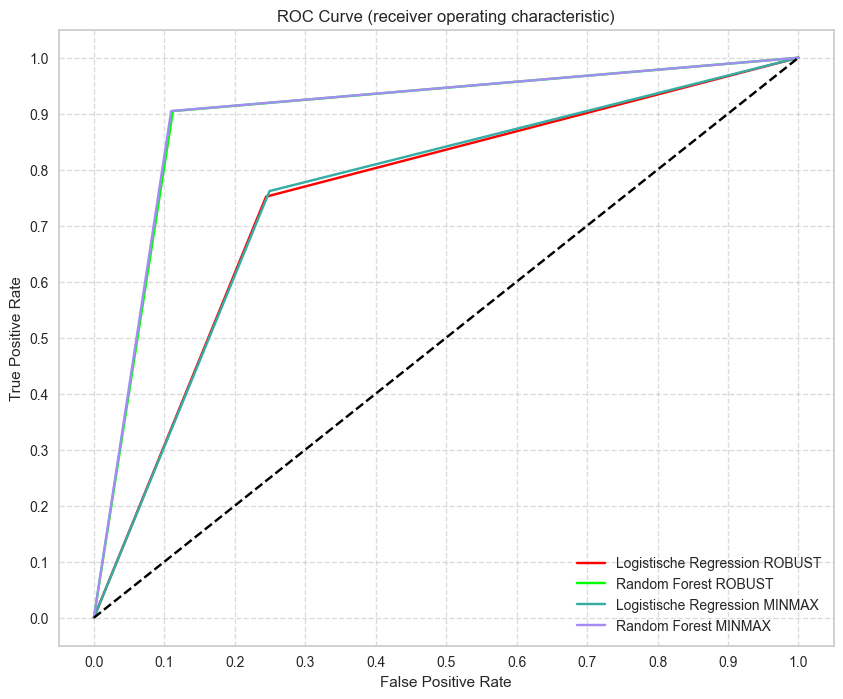

In [24]:
# ROC
logreg_roc_curve = roc_curve(y_test, logreg_pred_01)
rf_roc_curve = roc_curve(y_test, rf_pred_01)
logreg_roc_curve_01B = roc_curve(y_test, logreg_pred_01B)
rf_roc_curve_01B = roc_curve(y_test, rf_pred_01B)

palette = sns.color_palette('husl', 4)

plt.figure(figsize=(10, 8))

# Plots mit Linien und Legende
plt.plot(logreg_roc_curve[0], logreg_roc_curve[1], label='Logistische Regression ROBUST', color='red')
plt.plot(rf_roc_curve[0], rf_roc_curve[1], label='Random Forest ROBUST', color='lime')
plt.plot(logreg_roc_curve_01B[0], logreg_roc_curve_01B[1], label='Logistische Regression MINMAX', color=palette[2])
plt.plot(rf_roc_curve_01B[0], rf_roc_curve_01B[1], label='Random Forest MINMAX', color=palette[3])
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (receiver operating characteristic)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))

plt.show()


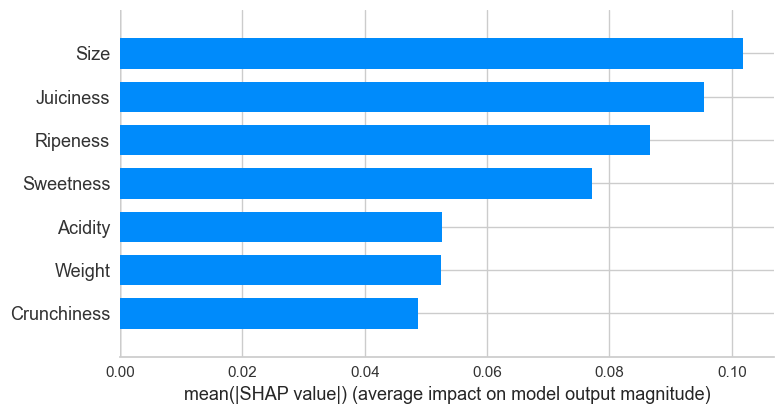

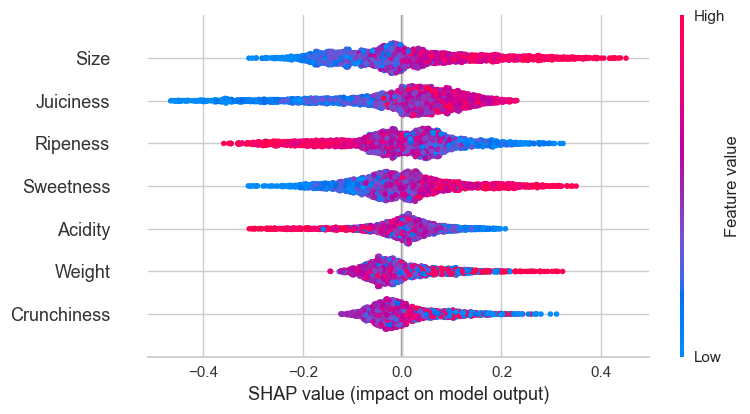

In [25]:
# explainable AI für random forest minmax
explainer = shap.TreeExplainer(rf_model_01B)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values[1], X_train, plot_type="bar")

shap.summary_plot(shap_values[1], X_train)

In [26]:
# Kopie des DataFrames
df_reduced = df.copy()

# Features
quantitative_features_Modell_02 = ['Size', 'Ripeness', 'Juiciness', 'Sweetness', 'Acidity']

# Transfomations-Pipeline
preprocessor_02 = ColumnTransformer(
    transformers=[
        ('min_max_scaler', MinMaxScaler(), quantitative_features_Modell_02)
    ])

# Anwendung der Transformation
X_02 =df_reduced[quantitative_features_Modell_02]
X_transformed_02 = preprocessor_02.fit_transform(X_02)

# neues DataFrame
X_transformed_df_02 = pd.DataFrame(X_transformed_02, columns=quantitative_features_Modell_02)

# Qualität hinzufügen
X_transformed_df_02['Quality'] = df_reduced['Quality']
print(X_transformed_df_02.head())

       Size  Ripeness  Juiciness  Sweetness   Acidity  Quality
0  0.234669  0.472770   0.585819   0.922484  0.452225        1
1  0.439331  0.513807   0.511408   0.795706  0.436185        1
2  0.505948  0.444693   0.660388   0.388567  0.668192        0
3  0.479014  0.187052   0.720370   0.619422  0.541180        1
4  0.628107  0.348084   0.674814   0.490589  0.521150        1


In [27]:
# Aufteilen der Daten in Trainings- und Testsets
X_train, X_test, y_train, y_test = train_test_split(X_transformed_df_02.drop('Quality', axis=1), df['Quality'], test_size=0.2, random_state=42)

# CatBoost
catboost_model_01 = CatBoostClassifier(random_state=42)
start_time = time.time()
catboost_model_01.fit(X_train, y_train)
end_time = time.time()
catboost_runtime = end_time - start_time
catboost_logloss = log_loss(y_test, catboost_model_01.predict_proba(X_test))

catboost_pred_01 = catboost_model_01.predict(X_test)

# Random Forest
rf_model_02 = RandomForestClassifier(random_state=42)
start_time = time.time()
rf_model_02.fit(X_train, y_train)
end_time = time.time()
rf_runtime_02 = end_time - start_time
rf_model_logloss_02 = log_loss(y_test, rf_model_02.predict_proba(X_test))

rf_pred_02 = rf_model_02.predict(X_test)

# Modellperformance
print("CatBoost:")
print(classification_report(y_test, catboost_pred_01), "%")
print("Genauigkeit (Accuracy):", accuracy_score(y_test, catboost_pred_01), "%")
print("Laufzeit:", catboost_runtime, "Sek.")
print("Sicherheit:", catboost_logloss, "%")

print("\nRandom Forest:")
print(classification_report(y_test, rf_pred_02), "%")
print("Genauigkeit (Accuracy):", accuracy_score(y_test, rf_pred_02), "%")
print("Laufzeit:", rf_runtime_02, "Sek.")
print("Sicherheit:", rf_model_logloss_02, "%")

Learning rate set to 0.016929
0:	learn: 0.6832707	total: 109ms	remaining: 1m 49s
1:	learn: 0.6748243	total: 116ms	remaining: 58.1s
2:	learn: 0.6665306	total: 122ms	remaining: 40.7s
3:	learn: 0.6602509	total: 128ms	remaining: 31.8s
4:	learn: 0.6520807	total: 133ms	remaining: 26.4s
5:	learn: 0.6444576	total: 139ms	remaining: 23s
6:	learn: 0.6376440	total: 145ms	remaining: 20.5s
7:	learn: 0.6299433	total: 151ms	remaining: 18.7s
8:	learn: 0.6230281	total: 157ms	remaining: 17.3s
9:	learn: 0.6167137	total: 162ms	remaining: 16s
10:	learn: 0.6110815	total: 168ms	remaining: 15.1s
11:	learn: 0.6042362	total: 174ms	remaining: 14.4s
12:	learn: 0.5979945	total: 180ms	remaining: 13.7s
13:	learn: 0.5919958	total: 187ms	remaining: 13.1s
14:	learn: 0.5881020	total: 193ms	remaining: 12.7s
15:	learn: 0.5830751	total: 199ms	remaining: 12.3s
16:	learn: 0.5781400	total: 205ms	remaining: 11.8s
17:	learn: 0.5741360	total: 210ms	remaining: 11.5s
18:	learn: 0.5693158	total: 216ms	remaining: 11.1s
19:	learn: 0.5

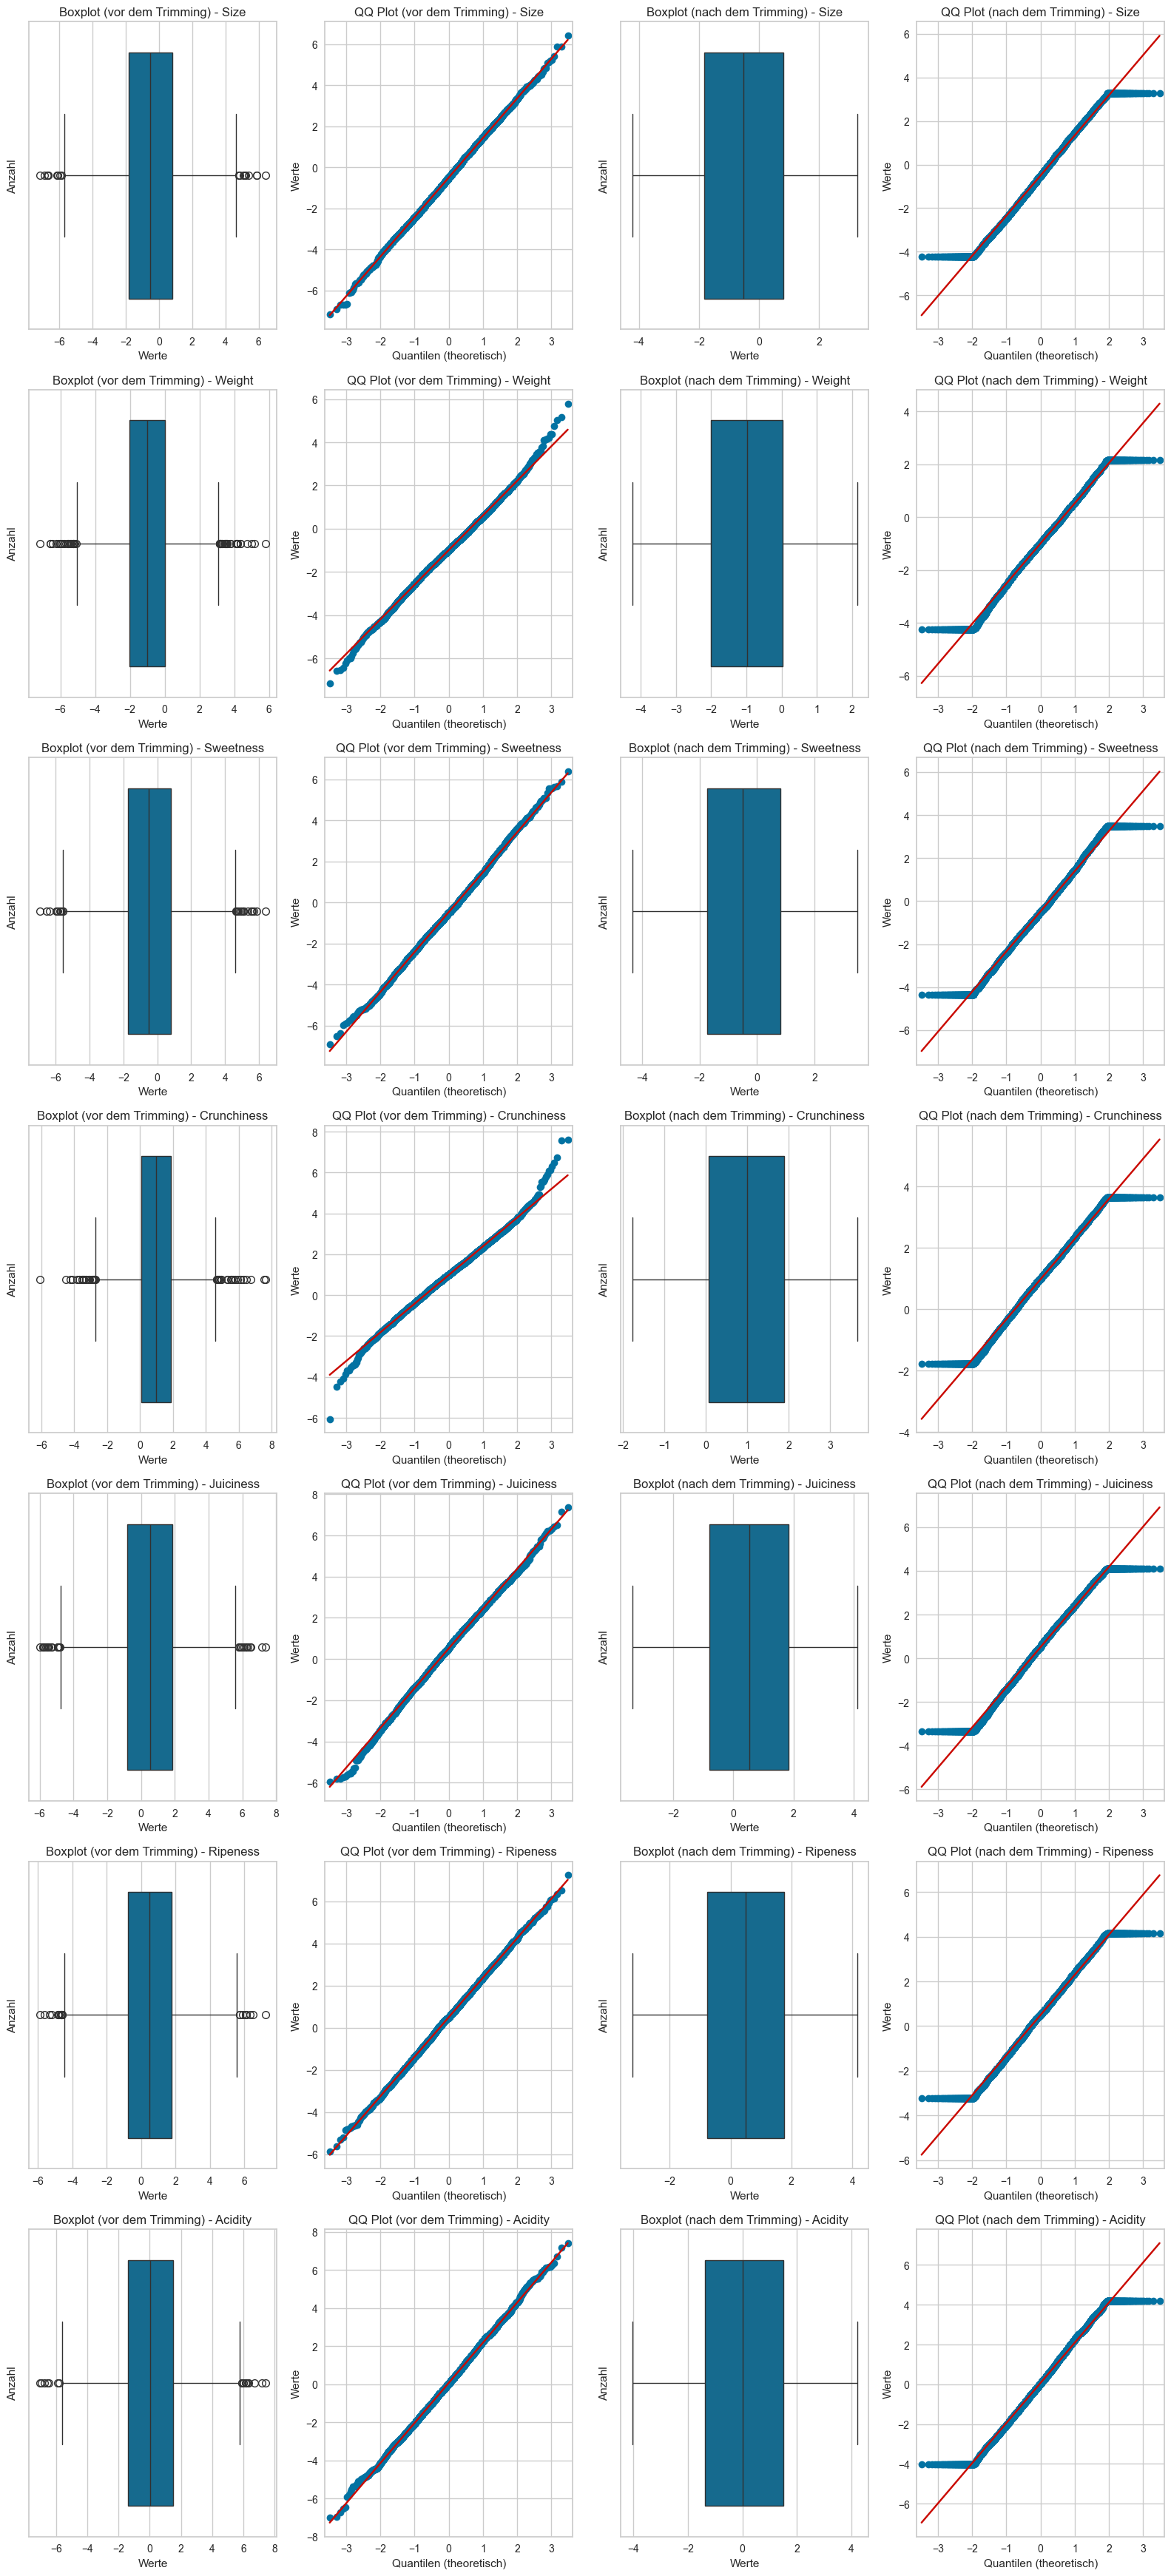

In [28]:
# Kategorien
categories = df.columns[1:8]
fig, axes = plt.subplots(nrows=len(categories), ncols=4, figsize=(16, 5 * len(categories)))

df_before_trim = df.copy()

for i, category in enumerate(categories):
    sns.boxplot(x=df_before_trim[category], ax=axes[i, 0])
    axes[i, 0].set_title(f'Boxplot (vor dem Trimming) - {category}')
    axes[i, 0].set_xlabel(f'Werte')
    axes[i, 0].set_ylabel(f'Anzahl')

    sm.qqplot(df_before_trim[category], line='s', ax=axes[i, 1])
    axes[i, 1].set_title(f'QQ Plot (vor dem Trimming) - {category}')
    axes[i, 1].set_xlabel(f'Quantilen (theoretisch)')
    axes[i, 1].set_ylabel(f'Werte')
    
    df[category] = winsorize(df[category], limits=[0.025, 0.025])

    sns.boxplot(x=df[category], ax=axes[i, 2])
    axes[i, 2].set_title(f'Boxplot (nach dem Trimming) - {category}')
    axes[i, 2].set_xlabel(f'Werte')
    axes[i, 2].set_ylabel(f'Anzahl')

    sm.qqplot(df[category], line='s', ax=axes[i, 3])
    axes[i, 3].set_title(f'QQ Plot (nach dem Trimming) - {category}')
    axes[i, 3].set_xlabel(f'Quantilen (theoretisch)')
    axes[i, 3].set_ylabel(f'Werte')

plt.tight_layout()
plt.show()


In [29]:
# Features
quantitative_features_Modell_03 = ['Size', 'Weight', 'Sweetness', 'Crunchiness', 'Juiciness', 'Ripeness', 'Acidity']

# Transfomations-Pipeline
preprocessor_03 = ColumnTransformer(
    transformers=[
        ('min_max_scaler', MinMaxScaler(), quantitative_features_Modell_03)
    ])

# Anwenden der Transformationen
X_03 = df.drop(['A_id', 'Quality'], axis=1)
X_transformed_03 = preprocessor_03.fit_transform(X_03)

# neues DataFrame
X_transformed_df_03 = pd.DataFrame(X_transformed_03, columns=X_03.columns)

# Qualität hinzufügen
X_transformed_df_03['Quality'] = df['Quality']
print(X_transformed_df_03.head())

       Size    Weight  Sweetness  Crunchiness  Juiciness  Ripeness   Acidity  \
0  0.033623  0.271461   1.000000     0.141389   0.696708  0.481979  0.430168   
1  0.404325  0.220363   1.000000     0.620386   0.563889  0.554748  0.402147   
2  0.524986  0.452933   0.332733     0.264700   0.829810  0.432193  0.807457   
3  0.476201  0.309084   0.724885     0.309784   0.936875  0.000000  0.585571   
4  0.746250  0.461478   0.506037     0.225943   0.855559  0.260882  0.550578   

   Quality  
0        1  
1        1  
2        0  
3        1  
4        1  


In [30]:
# Aufteilen der Daten in Trainings- und Testsets
X_train, X_test, y_train, y_test = train_test_split(X_transformed_df_03.drop('Quality', axis=1), df['Quality'], test_size=0.2, random_state=42)

# CatBoost
from catboost import CatBoostClassifier
catboost_model_02 = CatBoostClassifier(random_state=42)
start_time = time.time()
catboost_model_02.fit(X_train, y_train)
end_time = time.time()
catboost_runtime_02 = end_time - start_time
catboost_logloss_02 = log_loss(y_test, catboost_model_02.predict_proba(X_test))

catboost_pred_02 = catboost_model_02.predict(X_test)

# Random Forest
rf_model_03 = RandomForestClassifier(random_state=42)
start_time = time.time()
rf_model_03.fit(X_train, y_train)
end_time = time.time()
rf_runtime_03 = end_time - start_time
catboost_logloss_03 = log_loss(y_test, rf_model_03.predict_proba(X_test))

rf_pred_03 = rf_model_03.predict(X_test)

# Modellperformance
print("CatBoost:")
print(classification_report(y_test, catboost_pred_02), "%")
print("Genauigkeit (Accuracy):", accuracy_score(y_test, catboost_pred_02), "%")
print("Laufzeit:", catboost_runtime_02, "Sek.")
print("Sicherheit:", catboost_logloss_02, "%")

print("\nRandom Forest:")
print(classification_report(y_test, rf_pred_03), "%")
print("Genauigkeit (Accuracy):", accuracy_score(y_test, rf_pred_03), "%")
print("Laufzeit:", rf_runtime_03, "Sek.")
print("Sicherheit:", catboost_logloss_03, "%")

Learning rate set to 0.016929
0:	learn: 0.6834183	total: 9.91ms	remaining: 9.9s
1:	learn: 0.6752403	total: 16.1ms	remaining: 8.04s
2:	learn: 0.6677411	total: 25.2ms	remaining: 8.38s
3:	learn: 0.6596728	total: 31.4ms	remaining: 7.81s
4:	learn: 0.6520811	total: 38.9ms	remaining: 7.74s
5:	learn: 0.6441821	total: 44.7ms	remaining: 7.41s
6:	learn: 0.6362135	total: 51.2ms	remaining: 7.26s
7:	learn: 0.6287361	total: 59ms	remaining: 7.31s
8:	learn: 0.6221282	total: 65.7ms	remaining: 7.23s
9:	learn: 0.6148187	total: 74.4ms	remaining: 7.36s
10:	learn: 0.6089859	total: 84.2ms	remaining: 7.57s
11:	learn: 0.6034351	total: 90.8ms	remaining: 7.48s
12:	learn: 0.5975565	total: 97.1ms	remaining: 7.37s
13:	learn: 0.5921529	total: 105ms	remaining: 7.37s
14:	learn: 0.5867397	total: 111ms	remaining: 7.31s
15:	learn: 0.5811266	total: 118ms	remaining: 7.25s
16:	learn: 0.5767311	total: 123ms	remaining: 7.13s
17:	learn: 0.5732590	total: 129ms	remaining: 7.03s


18:	learn: 0.5677320	total: 137ms	remaining: 7.05s
19:	learn: 0.5634808	total: 143ms	remaining: 6.98s
20:	learn: 0.5595285	total: 148ms	remaining: 6.89s
21:	learn: 0.5547235	total: 153ms	remaining: 6.82s
22:	learn: 0.5512988	total: 159ms	remaining: 6.76s
23:	learn: 0.5467294	total: 165ms	remaining: 6.72s
24:	learn: 0.5418116	total: 171ms	remaining: 6.67s
25:	learn: 0.5378403	total: 177ms	remaining: 6.62s
26:	learn: 0.5338705	total: 184ms	remaining: 6.64s
27:	learn: 0.5301520	total: 190ms	remaining: 6.6s
28:	learn: 0.5262353	total: 196ms	remaining: 6.57s
29:	learn: 0.5226735	total: 202ms	remaining: 6.54s
30:	learn: 0.5192514	total: 208ms	remaining: 6.51s
31:	learn: 0.5154963	total: 215ms	remaining: 6.5s
32:	learn: 0.5126522	total: 221ms	remaining: 6.48s
33:	learn: 0.5100865	total: 228ms	remaining: 6.47s
34:	learn: 0.5066682	total: 234ms	remaining: 6.46s
35:	learn: 0.5031664	total: 241ms	remaining: 6.45s
36:	learn: 0.4998894	total: 248ms	remaining: 6.45s
37:	learn: 0.4975536	total: 254ms

### Review

In [31]:
# Vergleich der Modelle
df_performance = pd.DataFrame(columns=['Model', 'Accuracy', 'Logloss', 'Recall', 'Runtime'])

df_performance.loc[0] = ['Logistische Regression - ROBUST', accuracy_score(y_test, logreg_pred_01), log_loss(y_test, logreg_pred_01), recall_score(y_test, logreg_pred_01), logreg_runtime]
df_performance.loc[1] = ['Logistische Regression - MINMAX', accuracy_score(y_test, logreg_pred_01B), log_loss(y_test, logreg_pred_01B), recall_score(y_test, logreg_pred_01B), logreg_runtime_01B]

df_performance.loc[2] = ['Random Forest - ROBUST', accuracy_score(y_test, rf_pred_01), log_loss(y_test, rf_pred_01), recall_score(y_test, rf_pred_01), rf_runtime]
df_performance.loc[3] = ['Random Forest - MINMAX', accuracy_score(y_test, rf_pred_01B), log_loss(y_test, rf_pred_01B), recall_score(y_test, rf_pred_01B), rf_runtime_01B]

df_performance.loc[4] = ['CatBoost - reduced Features', accuracy_score(y_test, catboost_pred_01), log_loss(y_test, catboost_pred_01), recall_score(y_test, catboost_pred_01), catboost_runtime]
df_performance.loc[5] = ['CatBoost - nach dem Trimming', accuracy_score(y_test, catboost_pred_02), log_loss(y_test, catboost_pred_02), recall_score(y_test, catboost_pred_02), catboost_runtime_02]

df_performance.loc[6] = ['Random Forest - reduced Features', accuracy_score(y_test, rf_pred_02), log_loss(y_test, rf_pred_02), recall_score(y_test, rf_pred_02), rf_runtime_02]
df_performance.loc[7] = ['Random Forest - nach dem Trimming', accuracy_score(y_test, rf_pred_03), log_loss(y_test, rf_pred_03), recall_score(y_test, rf_pred_03), rf_runtime_03]

# Sortieren nach Accuracy
df_performance.sort_values(by='Accuracy', ascending=False, inplace=True)
df_performance.reset_index(drop=True, inplace=True)
df_performance


,Model,Accuracy,Logloss,Recall,Runtime
0,CatBoost - nach dem Trimming,0.91125,3.198874,0.922306,6.376297
1,Random Forest - MINMAX,0.89750,3.694474,0.904762,1.576325
2,Random Forest - ROBUST,0.89625,3.739529,0.904762,1.576325
3,Random Forest - nach dem Trimming,0.89625,3.739529,0.894737,1.565154
4,CatBoost - reduced Features,0.86250,4.956002,0.869674,6.230653
5,Random Forest - reduced Features,0.85750,5.136221,0.857143,1.598204
6,Logistische Regression - MINMAX,0.75625,8.785641,0.761905,1.576325
7,Logistische Regression - ROBUST,0.75375,8.875750,0.751880,0.034256


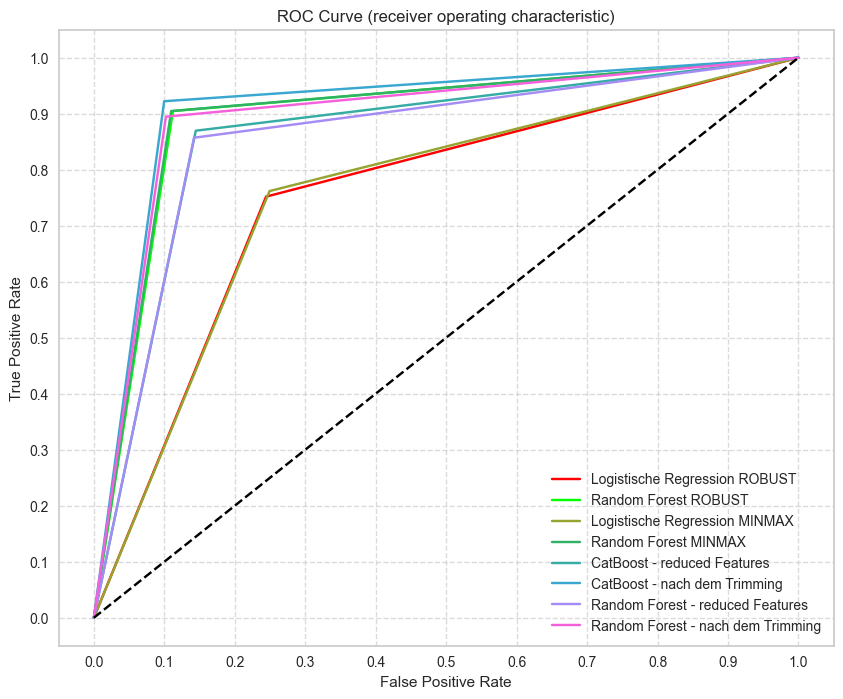

In [32]:
# ROC Curve für alle Modelle
logreg_roc_curve = roc_curve(y_test, logreg_pred_01)
rf_roc_curve = roc_curve(y_test, rf_pred_01)
logreg_roc_curve_01B = roc_curve(y_test, logreg_pred_01B)
rf_roc_curve_01B = roc_curve(y_test, rf_pred_01B)
catboost_roc_curve_01 = roc_curve(y_test, catboost_pred_01)
catboost_roc_curve_02 = roc_curve(y_test, catboost_pred_02)
rf_roc_curve_02 = roc_curve(y_test, rf_pred_02)
rf_roc_curve_03 = roc_curve(y_test, rf_pred_03)

palette = sns.color_palette('husl', 8)

plt.figure(figsize=(10, 8))

# Plots mit Linien und Legende
plt.plot(logreg_roc_curve[0], logreg_roc_curve[1], label='Logistische Regression ROBUST', color='red')
plt.plot(rf_roc_curve[0], rf_roc_curve[1], label='Random Forest ROBUST', color='lime')
plt.plot(logreg_roc_curve_01B[0], logreg_roc_curve_01B[1], label='Logistische Regression MINMAX', color=palette[2])
plt.plot(rf_roc_curve_01B[0], rf_roc_curve_01B[1], label='Random Forest MINMAX', color=palette[3])
plt.plot(catboost_roc_curve_01[0], catboost_roc_curve_01[1], label='CatBoost - reduced Features', color=palette[4])
plt.plot(catboost_roc_curve_02[0], catboost_roc_curve_02[1], label='CatBoost - nach dem Trimming', color=palette[5])
plt.plot(rf_roc_curve_02[0], rf_roc_curve_02[1], label='Random Forest - reduced Features', color=palette[6])
plt.plot(rf_roc_curve_03[0], rf_roc_curve_03[1], label='Random Forest - nach dem Trimming', color=palette[7])
plt.plot([0, 1], [0, 1], color='black', linestyle='--')

plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (receiver operating characteristic)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))

plt.show()


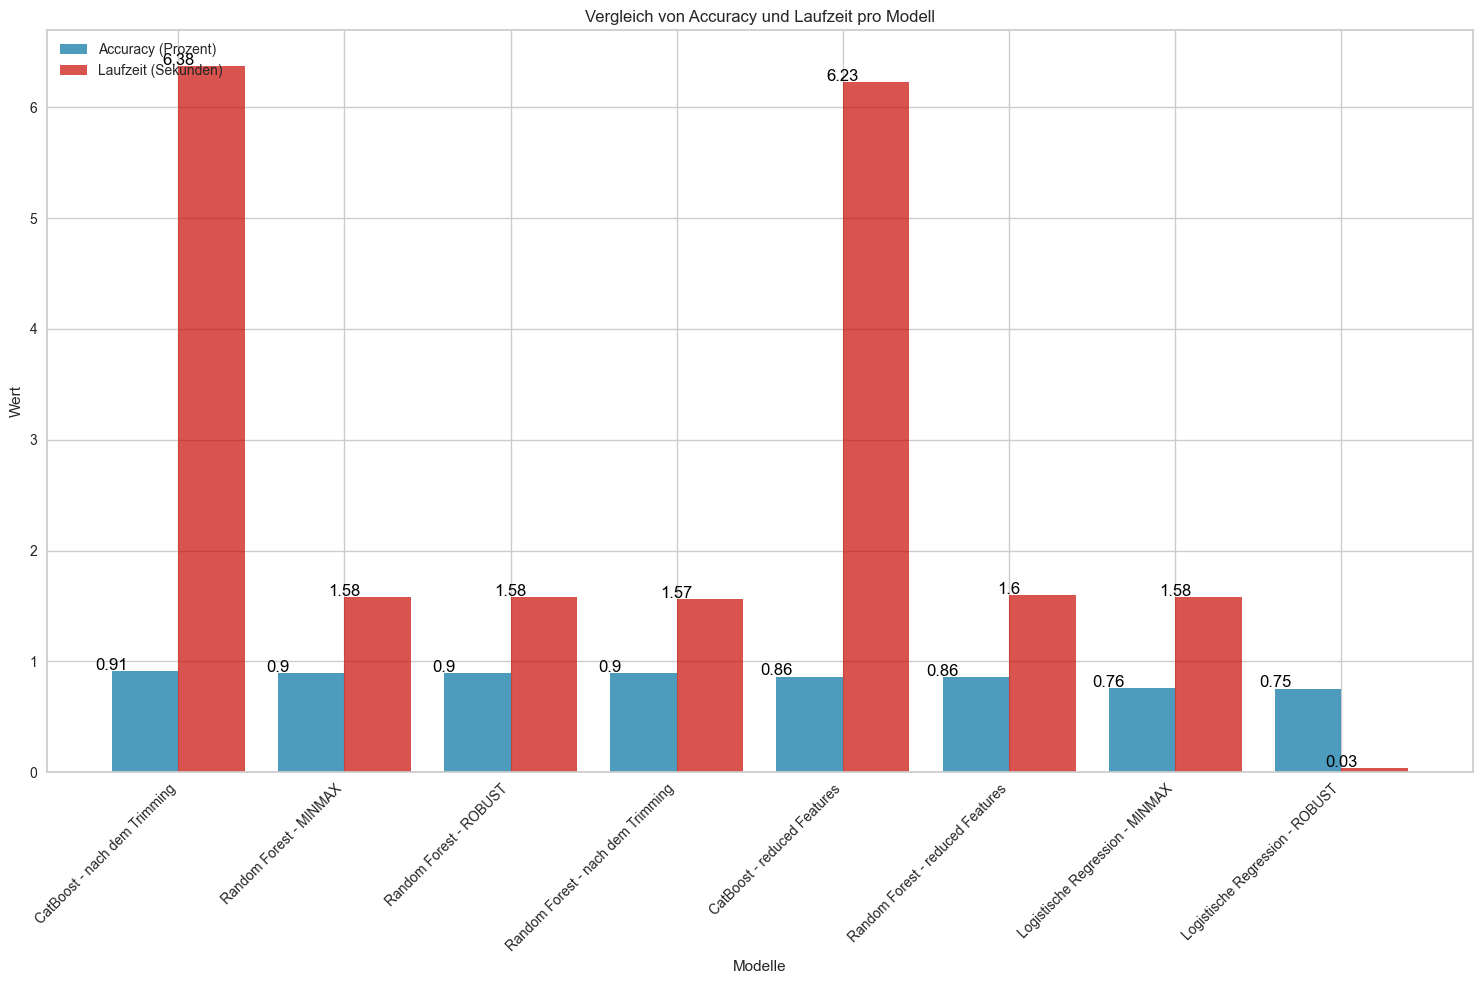

In [33]:
# Balkendiagramm
fig, ax = plt.subplots(figsize=(15, 10))
bar_width = 0.4
# Positionen für die Balken
index = np.arange(len(df_performance))

# Accuracy
bars1 = ax.bar(index, df_performance['Accuracy'], bar_width, color='b', alpha=0.7, label='Accuracy (Prozent)')
index = index + bar_width

# Runtime
bars2 = ax.bar(index, df_performance['Runtime'], bar_width, color='r', alpha=0.7, label='Laufzeit (Sekunden)')

# Beschriftungen&Legende
ax.set_xlabel('Modelle')
ax.set_ylabel('Wert')
ax.set_title('Vergleich von Accuracy und Laufzeit pro Modell')
ax.set_xticks(index - bar_width / 2)
ax.set_xticklabels(df_performance['Model'], rotation=45, ha="right")
ax.legend(loc='upper left')


ax.legend(handles=[bars1, bars2], loc='upper left')

# Wertbeschriftungen
for i, v in enumerate(df_performance['Accuracy']):
    ax.text(i - bar_width / 2, v + 0.01, str(round(v, 2)), color='black', ha='center')

for i, v in enumerate(df_performance['Runtime']):
    ax.text(i + bar_width / 2, v + 0.01, str(round(v, 2)), color='black', ha='center')

plt.tight_layout()
plt.show()

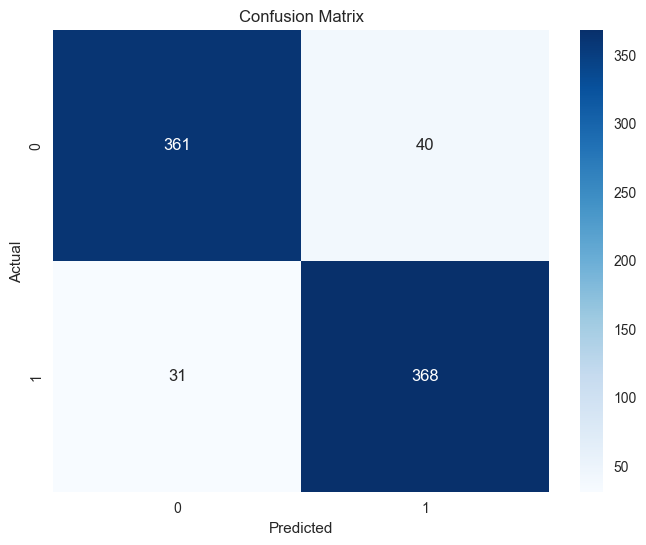

In [34]:
# Confusion Matrix Catboost02
cm = confusion_matrix(y_test, catboost_pred_02)

# Erstelle die Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

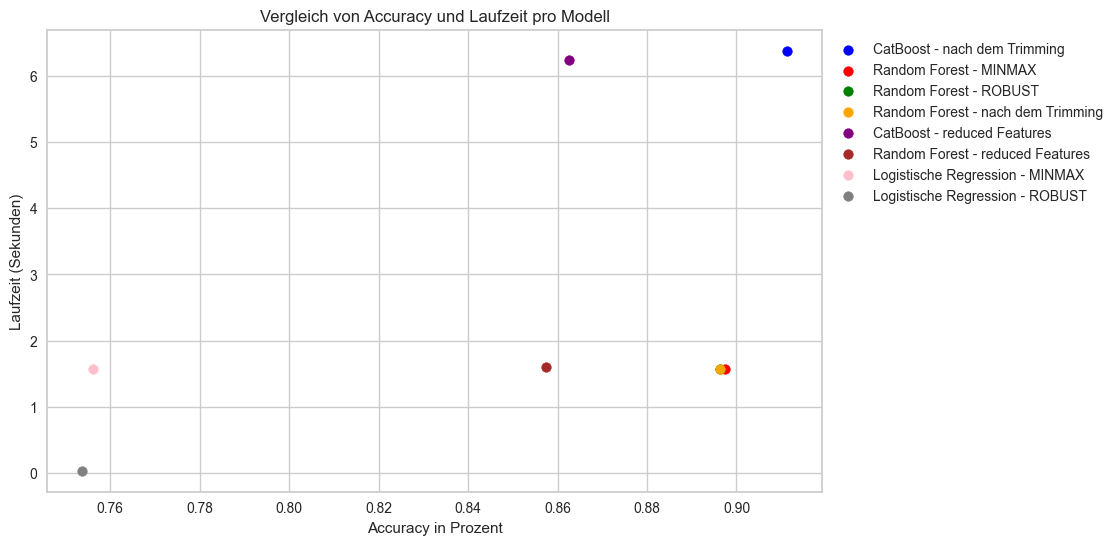

In [35]:
models = df_performance['Model']
accuracies = df_performance['Accuracy']
runtimes = df_performance['Runtime']

colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

plt.figure(figsize=(10, 6))

# Scatter Plot
for i in range(len(models)):
    plt.scatter(accuracies[i], runtimes[i], c=colors[i], marker='o', label=models[i])

# Achsenbeschriftungen
plt.xlabel('Accuracy in Prozent')
plt.ylabel('Laufzeit (Sekunden)')
plt.title('Vergleich von Accuracy und Laufzeit pro Modell')

# Legende
plt.legend(bbox_to_anchor=(1, 1))

# Raster anzeigen
plt.grid(True)

plt.show()

### Kreuzvalidierung

In [36]:
print("CatBoost:")
cv_scores_catboost = cross_val_score(catboost_model_02, X_train, y_train ,cv=10)
print(cv_scores_catboost)
print("Durchschnittliche Accuracy:", np.mean(cv_scores_catboost))
print("Standardabweichung:", np.std(cv_scores_catboost))
print("durchschnittliche Laufzeit:", np.mean(catboost_runtime_02))
print("durchschnittliche Logloss:", np.mean(catboost_logloss_02))

print("Random Forest:")
cv_scores_rf = cross_val_score(rf_model_03, X_train, y_train, cv=10)
print(cv_scores_rf)
print("Durchschnittliche Accuracy:", np.mean(cv_scores_rf))
print("durchschnitlliche Laufzeit:", np.mean(rf_runtime_03))
print("Standardabweichung:", np.std(cv_scores_rf))
print("durchschnittliche Laufzeit:", np.mean(rf_runtime_03))
print("durchschnittliche Logloss:", np.mean(catboost_logloss_03))

CatBoost:
Learning rate set to 0.016184
0:	learn: 0.6850674	total: 19.5ms	remaining: 19.5s
1:	learn: 0.6767925	total: 48.5ms	remaining: 24.2s
2:	learn: 0.6681086	total: 59.1ms	remaining: 19.6s
3:	learn: 0.6600589	total: 69.4ms	remaining: 17.3s
4:	learn: 0.6525440	total: 78ms	remaining: 15.5s
5:	learn: 0.6448168	total: 87.1ms	remaining: 14.4s
6:	learn: 0.6368060	total: 94.2ms	remaining: 13.4s
7:	learn: 0.6308342	total: 101ms	remaining: 12.6s
8:	learn: 0.6234767	total: 108ms	remaining: 11.9s
9:	learn: 0.6175362	total: 114ms	remaining: 11.3s
10:	learn: 0.6119262	total: 121ms	remaining: 10.9s
11:	learn: 0.6074288	total: 128ms	remaining: 10.5s
12:	learn: 0.6014650	total: 134ms	remaining: 10.1s
13:	learn: 0.5956663	total: 140ms	remaining: 9.87s
14:	learn: 0.5906789	total: 147ms	remaining: 9.63s
15:	learn: 0.5858691	total: 154ms	remaining: 9.49s
16:	learn: 0.5808493	total: 161ms	remaining: 9.3s
17:	learn: 0.5756089	total: 167ms	remaining: 9.13s
18:	learn: 0.5711020	total: 174ms	remaining: 8.9

### Pycaret

In [37]:
exp_clf = setup(data = df, target = 'Quality', session_id=42, log_experiment=True, experiment_name='apple_quality')
best_model = compare_models()
print(best_model)

,Description,Value
0,Session id,42
1,Target,Quality
2,Target type,Binary
3,Original data shape,"(4000, 9)"
4,Transformed data shape,"(4000, 9)"
5,Transformed train set shape,"(2800, 9)"
6,Transformed test set shape,"(1200, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8936,0.9592,0.9066,0.8846,0.8953,0.7871,0.7877,1.4550
et,Extra Trees Classifier,0.8871,0.9548,0.8959,0.8818,0.8884,0.7743,0.7751,0.1240
lightgbm,Light Gradient Boosting Machine,0.8854,0.9553,0.9017,0.8741,0.8874,0.7707,0.7715,0.1650
rf,Random Forest Classifier,0.8843,0.9494,0.9016,0.8727,0.8865,0.7685,0.7697,0.1740
xgboost,Extreme Gradient Boosting,0.8796,0.9533,0.8845,0.8772,0.8806,0.7593,0.7598,0.0630
gbc,Gradient Boosting Classifier,0.8586,0.9330,0.8774,0.8469,0.8615,0.7171,0.7182,0.2260
qda,Quadratic Discriminant Analysis,0.8554,0.9346,0.8610,0.8532,0.8565,0.7107,0.7117,0.0190
dt,Decision Tree Classifier,0.8054,0.8053,0.8104,0.8045,0.8070,0.6107,0.6115,0.0210
ada,Ada Boost Classifier,0.7668,0.8454,0.7762,0.7654,0.7692,0.5335,0.5356,0.0850
nb,Naive Bayes,0.7511,0.8299,0.7526,0.7519,0.7514,0.5021,0.5031,0.0150


In [38]:
# Ausgabe Hyperparameter des tuned catboosts
catboost = create_model('catboost')
tuned_catboost = tune_model(catboost)
plot_model(tuned_catboost, plot='parameter')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,17:08:27
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,CatBoost Classifier


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9250,0.9758,0.9357,0.9161,0.9258,0.8500,0.8502
1,0.8750,0.9650,0.8857,0.8671,0.8763,0.7500,0.7502
2,0.8821,0.9567,0.8929,0.8741,0.8834,0.7643,0.7645
3,0.8643,0.9420,0.9000,0.8400,0.8690,0.7286,0.7304
4,0.8929,0.9551,0.9143,0.8767,0.8951,0.7857,0.7864
5,0.8964,0.9523,0.9143,0.8828,0.8982,0.7929,0.7934
6,0.9143,0.9635,0.8929,0.9328,0.9124,0.8286,0.8293
7,0.9179,0.9599,0.9291,0.9097,0.9193,0.8357,0.8359
8,0.8750,0.9553,0.9007,0.8581,0.8789,0.7499,0.7508


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9036,0.9683,0.9143,0.8951,0.9046,0.8071,0.8073
1,0.8750,0.9517,0.8929,0.8621,0.8772,0.7500,0.7505
2,0.8571,0.9473,0.8929,0.8333,0.8621,0.7143,0.7161
3,0.8500,0.9258,0.8857,0.8267,0.8552,0.7000,0.7018
4,0.8500,0.9364,0.8429,0.8551,0.8489,0.7000,0.7001
5,0.8571,0.9357,0.8714,0.8472,0.8592,0.7143,0.7146
6,0.8893,0.9523,0.8500,0.9225,0.8848,0.7786,0.7810
7,0.9071,0.9463,0.9220,0.8966,0.9091,0.8142,0.8146
8,0.8536,0.9485,0.8723,0.8425,0.8571,0.7071,0.7075


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Parameters
nan_mode,Min
eval_metric,Logloss
iterations,1000
sampling_frequency,PerTree
leaf_estimation_method,Newton
random_score_type,NormalWithModelSizeDecrease
grow_policy,SymmetricTree
penalties_coefficient,1
boosting_type,Plain
model_shrink_mode,Constant


In [39]:
# Ausgabe der Hyperparameter 

df_tuned_catboost = pd.DataFrame([tuned_catboost.get_all_params()])
df_tuned_catboost

df_catboost_02 = pd.DataFrame([catboost_model_02.get_all_params()])
df_catboost_02

df_rfmodel_03 = pd.DataFrame([rf_model_03.get_params()])
df_rfmodel_03


df_tuned_catboost['Model'] = 'Tuned CatBoost'
df_catboost_02['Model'] = 'CatBoost 02'
df_rfmodel_03['Model'] = 'RF Model 03'

# Concat der DataFrames
df_parameters = pd.concat([df_tuned_catboost, df_catboost_02, df_rfmodel_03], axis=0)
df_parameters

,nan_mode,eval_metric,iterations,sampling_frequency,leaf_estimation_method,random_score_type,grow_policy,penalties_coefficient,boosting_type,model_shrink_mode,...,min_impurity_decrease,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,n_estimators,n_jobs,oob_score,random_state,verbose,warm_start
0,Min,Logloss,1000.0,PerTree,Newton,NormalWithModelSizeDecrease,SymmetricTree,1.0,Plain,Constant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,Min,Logloss,1000.0,PerTree,Newton,NormalWithModelSizeDecrease,SymmetricTree,1.0,Plain,Constant,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,2.0,0.0,100.0,None,False,42.0,0.0,False


### Decision Tree

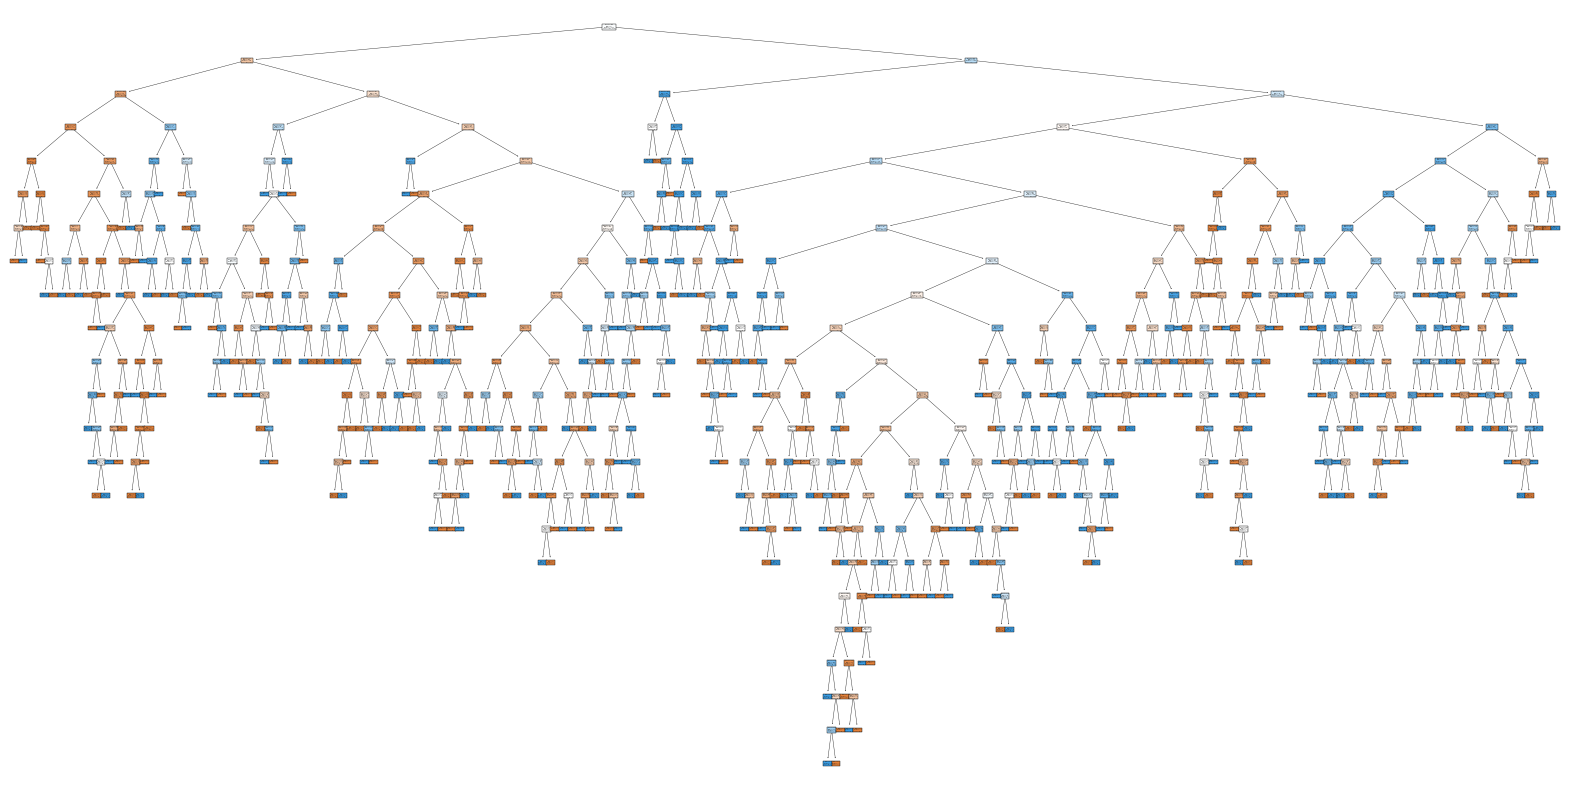

In [42]:
plt.figure(figsize=(20,10))
tree.plot_tree(rf_model_03.estimators_[0], filled=True)
plt.show()